In [6]:
! pip install scikit-image

  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/ce/d0/a3f60c9f57ed295b3076e4acdb29a37bbd8823452562ab2ad51b03d6f377/scikit_image-0.22.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/9b/82/473e452d3f21a9cd7e792a827f8df58bdff614fd2fff33d7bf6c4c128da7/imageio-2.31.6-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/f5/72/68ea763b5f3e3d9871492683059ed4724fd700dbe54aa03cdda7a9692129/tifffile-2023.9.26-py3-none-any.whl.metadata
  Obtaining dependency information for lazy_loader>=0.3 from https://files.pythonhosted.org/packages/a1/c3/65b3814e155836acacf720e5be3b5757130346670ac454fee29d3eda1381/lazy_loader-0.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ------


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/s eta 0:07:18
   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/s eta 0:07:18
   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/s eta 0:07:18
   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/s eta 0:07:18
   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/s eta 0:07:18
   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/s eta 0:07:18
   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/s eta 0:07:18
   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/s eta 0:07:18
   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/s eta 0:07:18
   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/s eta 0:07:18
   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/s eta 0:07:18
   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/s eta 0:07:18
   --------------------------------- ------ 20.3/24.5 MB 9.6 kB/

In [3]:
import cv2
import numpy as np
import scipy.ndimage
import scipy.sparse
import scipy.sparse.linalg
import skimage
from skimage import feature
from matplotlib import pyplot as plt
from numpy.lib.stride_tricks import as_strided

In [4]:
def plot_image(img, i, title='Input image'):
    plt.subplot(4, 2, i)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

In [5]:
def make_system(L, sparse_map, constraint_factor=0.001):
    '''
    :param L: Laplacian Matrix.
    Check the paper "A closed-form solution to natural image matting"
    :param sparse_map: Estimated sparse blur values
    :param constraint_factor: Internal parameter for propagation
    :return: System parameters to solve for defocus blur propagation
    '''
    spflatten = sparse_map.ravel()

    D = scipy.sparse.diags(spflatten)

    # combine constraints and graph laplacian
    A = constraint_factor * D + L
    # constrained values of known alpha values
    b = constraint_factor * D * spflatten

    return A, b

In [6]:
def g1x(x, y, s1):
    '''

    :param x:
    :param y:
    :param s1:
    :return:
    '''
    s1sq = s1 ** 2
    g = -1 * np.multiply(np.divide(x, 2 * np.pi * s1sq ** 2),
                         np.exp(-1 * np.divide(x ** 2 + y ** 2, 2 * s1sq)))

    return g


In [7]:
def g1y(x, y, s1):
    '''

    :param x:
    :param y:
    :param s1:
    :return:
    '''
    s1sq = s1 ** 2
    g = -1 * np.multiply(np.divide(y, 2 * np.pi * s1sq ** 2),
                         np.exp(-1 * np.divide(x ** 2 + y ** 2, 2 * s1sq)))

    return g


In [8]:
def get_laplacian(I, r=1):
    '''

    :param I: An RGB image [0-1]
    :param r: radius
    :return: The Laplacian matrix explained in Levin's paper
    '''
    eps = 0.0000001
    h, w, c = I.shape
    wr = (2 * r + 1) * (2 * r + 1)

    M_idx = np.arange(h * w).reshape(w, h).T
    n_vals = (w - 2 * r) * (h - 2 * r) * wr ** 2

    # data for matting laplacian in coordinate form
    row_idx = np.zeros(n_vals, dtype=np.int64)
    col_idx = np.zeros(n_vals, dtype=np.int64)
    vals = np.zeros(n_vals, dtype=np.float64)
    lenr = 0

    for j in range(r, h - r):
        for i in range(r, w - r):
            winr = I[j - r:j + r + 1, i - r:i + r + 1, 2]
            wing = I[j - r:j + r + 1, i - r:i + r + 1, 1]
            winb = I[j - r:j + r + 1, i - r:i + r + 1, 0]
            win_idx = M_idx[j - r:j + r + 1, i - r:i + r + 1].T.ravel()

            meanwinr = winr.mean()
            winrsq = np.multiply(winr, winr)
            varI_rr = winrsq.sum() / wr - meanwinr ** 2

            meanwing = wing.mean()
            wingsq = np.multiply(wing, wing)
            varI_gg = wingsq.sum() / wr - meanwing ** 2

            meanwinb = winb.mean()
            winbsq = np.multiply(winb, winb)
            varI_bb = winbsq.sum() / wr - meanwinb ** 2

            winrgsq = np.multiply(winr, wing)
            varI_rg = winrgsq.sum() / wr - meanwinr * meanwing

            winrbsq = np.multiply(winr, winb)
            varI_rb = winrbsq.sum() / wr - meanwinr * meanwinb

            wingbsq = np.multiply(wing, winb)
            varI_gb = wingbsq.sum() / wr - meanwing * meanwinb

            Sigma = np.array([[varI_rr, varI_rg, varI_rb],
                              [varI_rg, varI_gg, varI_gb],
                              [varI_rb, varI_gb, varI_bb]])

            meanI = np.array([meanwinr, meanwing, meanwinb])

            Sigma = Sigma + eps * np.eye(3)

            winI = np.zeros((wr, c))

            winI[:, 0] = winr.T.ravel()
            winI[:, 1] = wing.T.ravel()
            winI[:, 2] = winb.T.ravel()

            winI = winI - meanI

            inv_cov = np.linalg.inv(Sigma)
            tvals = (1 + np.matmul(np.matmul(winI, inv_cov), winI.T)) / wr

            row_idx[lenr:wr ** 2 + lenr] = np.tile(win_idx, (1, wr)).ravel()
            col_idx[lenr:wr ** 2 + lenr] = np.tile(win_idx, (wr, 1)).T.ravel()
            vals[lenr:wr ** 2 + lenr] = tvals.T.ravel()

            lenr += wr ** 2

    # Lsparse = scipy.sparse.coo_matrix((vals, (row_idx, col_idx)), shape=(h*w, h*w))
    Lsparse = scipy.sparse.coo_matrix((vals, (row_idx, col_idx)), shape=(w * h, w * h))

    row_idx2 = np.zeros(w * h, dtype=np.int64)
    col_idx2 = np.zeros(w * h, dtype=np.int64)
    vals2 = np.zeros(w * h, dtype=np.float64)

    row_idx2[:] = np.arange(w * h)
    col_idx2[:] = np.arange(w * h)
    vals2[:] = Lsparse.sum(axis=1).ravel()

    LDsparse = scipy.sparse.coo_matrix((vals2, (row_idx2, col_idx2)), shape=(w * h, w * h))

    return LDsparse - Lsparse


In [9]:
def estimate_sparse_blur(gimg, edge_map, std1, std2):
    '''

    :param gimg: Grayscale image
    :param edge_map: An edge map of the image
    :param std1: Standard deviation of reblurring
    :param std2: Standard deviation of second reblurring
    :return: Estimated sparse blur values at edge locations
    '''
    half_window = 11
    m = half_window * 2 + 1
    a = np.arange(-half_window, half_window + 1)
    xmesh = np.tile(a, (m, 1))
    ymesh = xmesh.T

    f11 = g1x(xmesh, ymesh, std1)
    f12 = g1y(xmesh, ymesh, std1)

    f21 = g1x(xmesh, ymesh, std2)
    f22 = g1y(xmesh, ymesh, std2)

    gimx1 = scipy.ndimage.convolve(gimg, f11, mode='nearest')
    gimy1 = scipy.ndimage.convolve(gimg, f12, mode='nearest')
    mg1 = np.sqrt(gimx1 ** 2 + gimy1 ** 2)
    plot_image(mg1, 3, 'gradient magnitude 1')

    gimx2 = scipy.ndimage.convolve(gimg, f21, mode='nearest')
    gimy2 = scipy.ndimage.convolve(gimg, f22, mode='nearest')
    mg2 = np.sqrt(gimx2 ** 2 + gimy2 ** 2)
    plot_image(mg1, 4, 'gradient magnitude 2')

    
    R = np.divide(mg1, mg2)
    plot_image(R, 5, 'ratio of gradient magnitudes')
    R = np.multiply(R, edge_map > 0)
    plot_image(R, 6, 'after multiplying with edge map')

    sparse_vals = np.divide(R ** 2 * (std1 ** 2) - (std2 ** 2), 1 - R ** 2)
    sparse_vals[sparse_vals < 0] = 0

    sparse_bmap = np.sqrt(sparse_vals)
    sparse_bmap[np.isnan(sparse_bmap)] = 0
    sparse_bmap[sparse_bmap > 5] = 5
    
    plot_image(sparse_bmap, 7, 'sparse blur map')
    return sparse_bmap


In [25]:
def _rolling_block(A, block=(3, 3)):
    """Applies sliding window to given matrix."""
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = (A.strides[0], A.strides[1]) + A.strides
    return as_strided(A, shape=shape, strides=strides)


def compute_laplacian(img: np.ndarray, mask=None, eps: float =10**(-7), win_rad: int =1):
    """Computes Matting Laplacian for a given image.

    Args:
        img: 3-dim numpy matrix with input image
        mask: mask of pixels for which Laplacian will be computed.
            If not set Laplacian will be computed for all pixels.
        eps: regularization parameter controlling alpha smoothness
            from Eq. 12 of the original paper. Defaults to 1e-7.
        win_rad: radius of window used to build Matting Laplacian (i.e.
            radius of omega_k in Eq. 12).
    Returns: sparse matrix holding Matting Laplacian.
    """

    win_size = (win_rad * 2 + 1) ** 2
    h, w, d = img.shape
    # Number of window centre indices in h, w axes
    c_h, c_w = h - 2 * win_rad, w - 2 * win_rad
    win_diam = win_rad * 2 + 1

    indsM = np.arange(h * w).reshape((h, w))
    ravelImg = img.reshape(h * w, d)
    win_inds = _rolling_block(indsM, block=(win_diam, win_diam))

    win_inds = win_inds.reshape(c_h, c_w, win_size)
    if mask is not None:
        mask = cv2.dilate(
            mask.astype(np.uint8),
            np.ones((win_diam, win_diam), np.uint8)
        ).astype(bool)
        win_mask = np.sum(mask.ravel()[win_inds], axis=2)
        win_inds = win_inds[win_mask > 0, :]
    else:
        win_inds = win_inds.reshape(-1, win_size)

    
    winI = ravelImg[win_inds]

    win_mu = np.mean(winI, axis=1, keepdims=True)
    win_var = np.einsum('...ji,...jk ->...ik', winI, winI) / win_size - np.einsum('...ji,...jk ->...ik', win_mu, win_mu)

    A = win_var + (eps/win_size)*np.eye(3)
    B = (winI - win_mu).transpose(0, 2, 1)
    X = np.linalg.solve(A, B).transpose(0, 2, 1)
    vals = np.eye(win_size) - (1.0/win_size)*(1 + X @ B)

    nz_indsCol = np.tile(win_inds, win_size).ravel()
    nz_indsRow = np.repeat(win_inds, win_size).ravel()
    nz_indsVal = vals.ravel()
    L = scipy.sparse.coo_matrix((nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h*w, h*w))

    # rewrite L in CSR format
    # L = scipy.sparse.csr_matrix((nz_indsVal, nz_indsCol, np.arange(0, nz_indsVal.shape[0] + 1, win_size)), shape=(h*w, h*w))
    return L


def closed_form_matting_with_prior(image, prior, prior_confidence, consts_map=None):
    """Applies closed form matting with prior alpha map to image.

    Args:
        image: 3-dim numpy matrix with input image.
        prior: matrix of same width and height as input image holding apriori alpha map.
        prior_confidence: matrix of the same shape as prior hodling confidence of prior alpha.
        consts_map: binary mask of pixels that aren't expected to change due to high
            prior confidence.

    Returns: 2-dim matrix holding computed alpha map.
    """

    assert image.shape[:2] == prior.shape, ('prior must be 2D matrix with height and width equal '
                                            'to image.')
    assert image.shape[:2] == prior_confidence.shape, ('prior_confidence must be 2D matrix with '
                                                       'height and width equal to image.')
    assert (consts_map is None) or image.shape[:2] == consts_map.shape, (
        'consts_map must be 2D matrix with height and width equal to image.')

    # logging.info('Computing Matting Laplacian.')
    laplacian = compute_laplacian(image, ~consts_map if consts_map is not None else None)
    confidence = scipy.sparse.diags(prior_confidence.ravel())
    # logging.info('Solving for alpha.')
    solution = scipy.sparse.linalg.spsolve(
        laplacian + confidence,
        prior.ravel() * prior_confidence.ravel()
    )
    alpha = np.minimum(np.maximum(solution.reshape(prior.shape), 0), 1)
    return alpha

def closed_form_matting_with_scribbles(image, scribbles, scribbles_confidence=0.0001):
    """Apply Closed-Form matting to given image using scribbles image."""

    assert image.shape == scribbles.shape, 'scribbles must have exactly same shape as image.'
    prior = (np.sum(scribbles, axis=2))

    # print(prior)
    # print(np.max(prior), np.min(prior), np.sum(prior))
    # return

    consts_map = prior != 0
    return closed_form_matting_with_prior(
        image,
        prior,
        scribbles_confidence * consts_map,
        consts_map
    )


In [26]:
def estimate_bmap_laplacian(img, sigma_c, std1, std2):
    '''
    :param img: An RGB image [0-255]
    :param sigma_c: Sigma parameter for Canny edge detector
    :param std1: Standard deviation of reblurring
    :param std2: Standard deviation of second reblurring
    :return: defocus blur map of the given image
    '''
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0
    plot_image(gimg, 1)
    edge_map = feature.canny(gimg, sigma_c)
    plot_image(gimg, 2, 'Edge Map')

    sparse_bmap = estimate_sparse_blur(gimg, edge_map, std1, std2)
    # h, w = sparse_bmap.shape

    # L1 = get_laplacian(img / 255.0)
    # A, b = make_system(L1, sparse_bmap.T)
    sparse_bmap = (sparse_bmap - np.min(sparse_bmap)) / (np.max(sparse_bmap) - np.min(sparse_bmap))
    sparse_bmap_rgb = cv2.merge((sparse_bmap, sparse_bmap, sparse_bmap))
    print(np.max(sparse_bmap_rgb), np.min(sparse_bmap_rgb), np.sum(sparse_bmap_rgb), sparse_bmap_rgb.shape)
    img = img/255.0

    
    # bmap = scipy.sparse.linalg.spsolve(A, b).reshape(w, h).T
    bmap = closed_form_matting_with_scribbles(img, sparse_bmap_rgb)
    plot_image(bmap, 8, 'final blur map')
    return bmap

1.0 0.0 4784.2011966395985 (300, 200, 3)


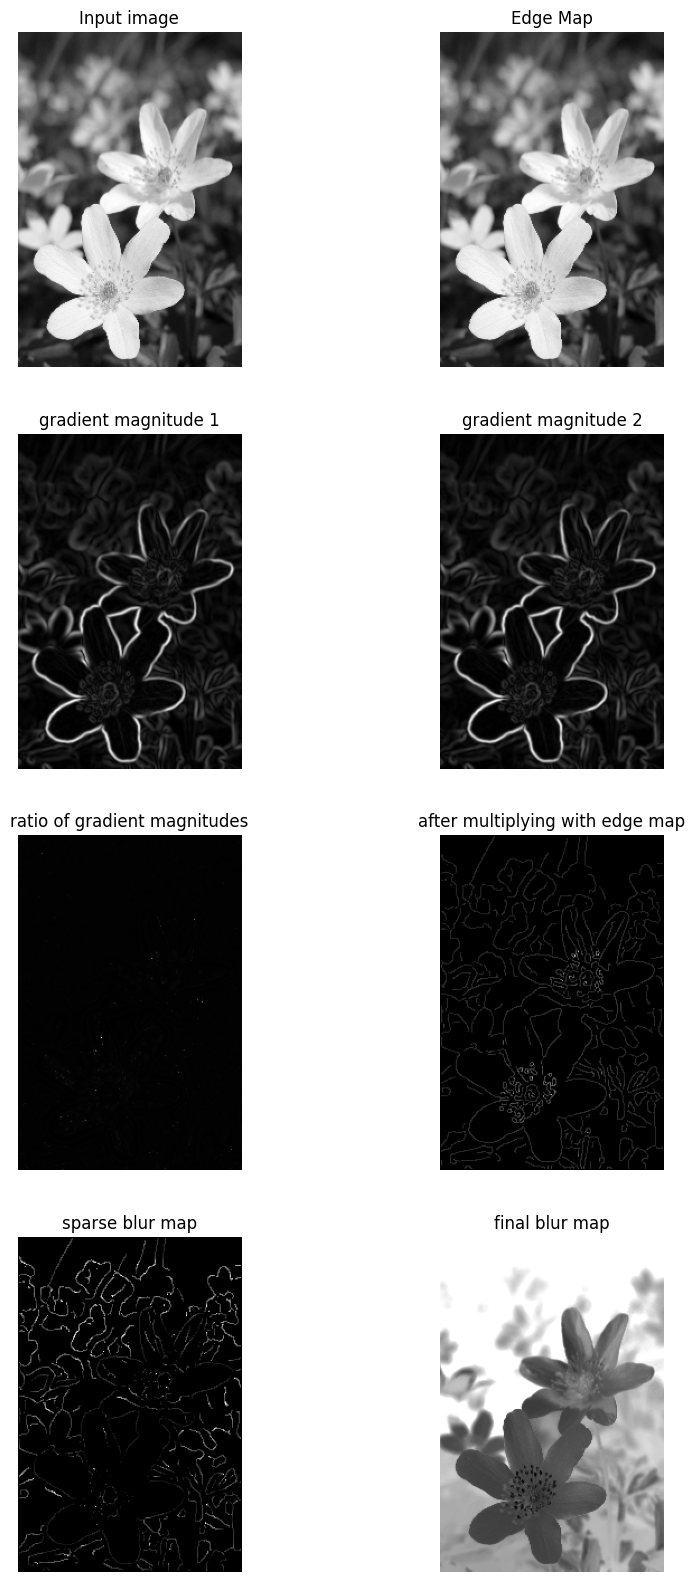

In [27]:
image_path = 'inputflower.png'
plt.figure(figsize=(10, 20))
img = cv2.imread(image_path)
img = cv2.resize(img, (200, 300))
fblurmap = estimate_bmap_laplacian(img, sigma_c = 1, std1 = 1, std2 = 1.5)

cv2.imwrite('_bmap2.png', np.uint8((fblurmap / fblurmap.max()) * 255))
np.save('_bmap.npy', fblurmap)